In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LinearRegression, LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [38]:
# Загрузка Restaurant Reviews
reviews = pd.read_csv("Restaurant_Reviews.csv", sep='\t')
print("Restaurant Reviews загружен")
print(reviews.shape)
reviews.head()

Restaurant Reviews загружен
(1000, 2)


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [39]:
# Загрузка NY Pricing
ny = pd.read_csv("NY Realstate Pricing.csv")
print("\nNY Realstate Pricing загружен")
print(ny.shape)
ny.head()


NY Realstate Pricing загружен
(17614, 12)


,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [40]:
print("Restaurant Reviews — распределение классов:")
print(reviews['Liked'].value_counts())

print("\nNY Pricing — статистика цены:")
ny['price'].describe()

Restaurant Reviews — распределение классов:
Liked
1    500
0    500
Name: count, dtype: int64

NY Pricing — статистика цены:


count    17614.000000
mean       145.455490
std        194.990677
min          0.000000
25%         70.000000
50%        109.000000
75%        170.000000
max       9999.000000
Name: price, dtype: float64

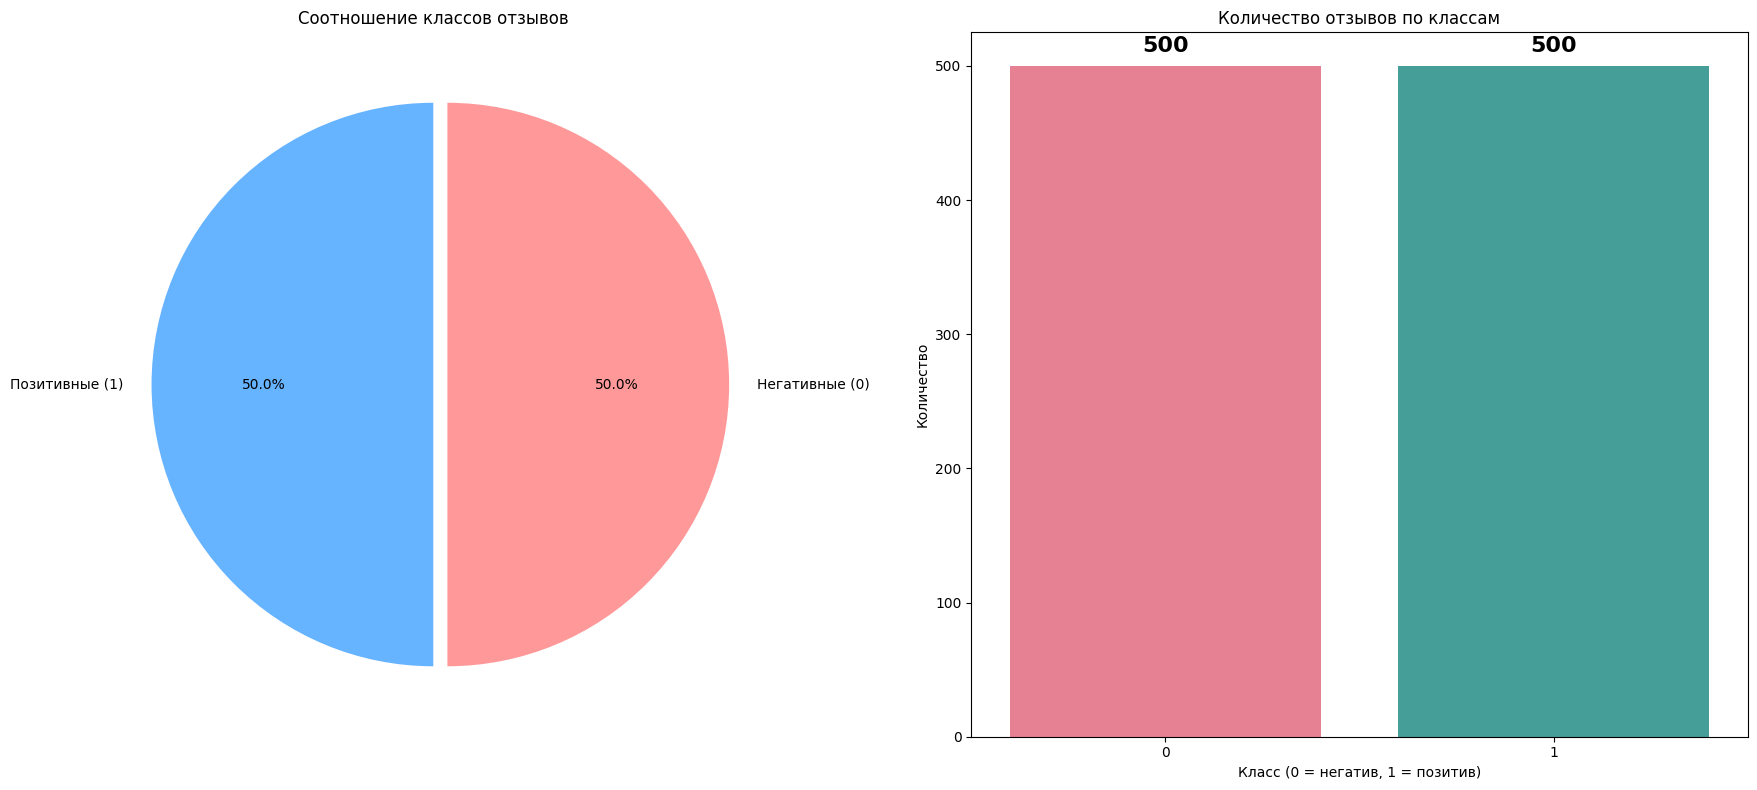

Позитивных отзывов: 500 (50.0%)
Негативных отзывов: 500 (50.0%)


In [41]:
# Круговая + столбчатая диаграмма распределения классов в Restaurant Reviews
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

likes_count = reviews['Liked'].value_counts()
axes[0].pie(likes_count.values, labels=['Позитивные (1)', 'Негативные (0)'], 
            autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'], explode=(0, 0.05))
axes[0].set_title('Соотношение классов отзывов')

sns.countplot(data=reviews, x='Liked', ax=axes[1], palette='husl')
axes[1].set_title('Количество отзывов по классам')
axes[1].set_xlabel('Класс (0 = негатив, 1 = позитив)')
axes[1].set_ylabel('Количество')
for i, v in enumerate(likes_count.values):
    axes[1].text(i, v + 10, str(v), ha='center', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Позитивных отзывов: {likes_count[1]} ({likes_count[1]/len(reviews)*100:.1f}%)")
print(f"Негативных отзывов: {likes_count[0]} ({likes_count[0]/len(reviews)*100:.1f}%)")

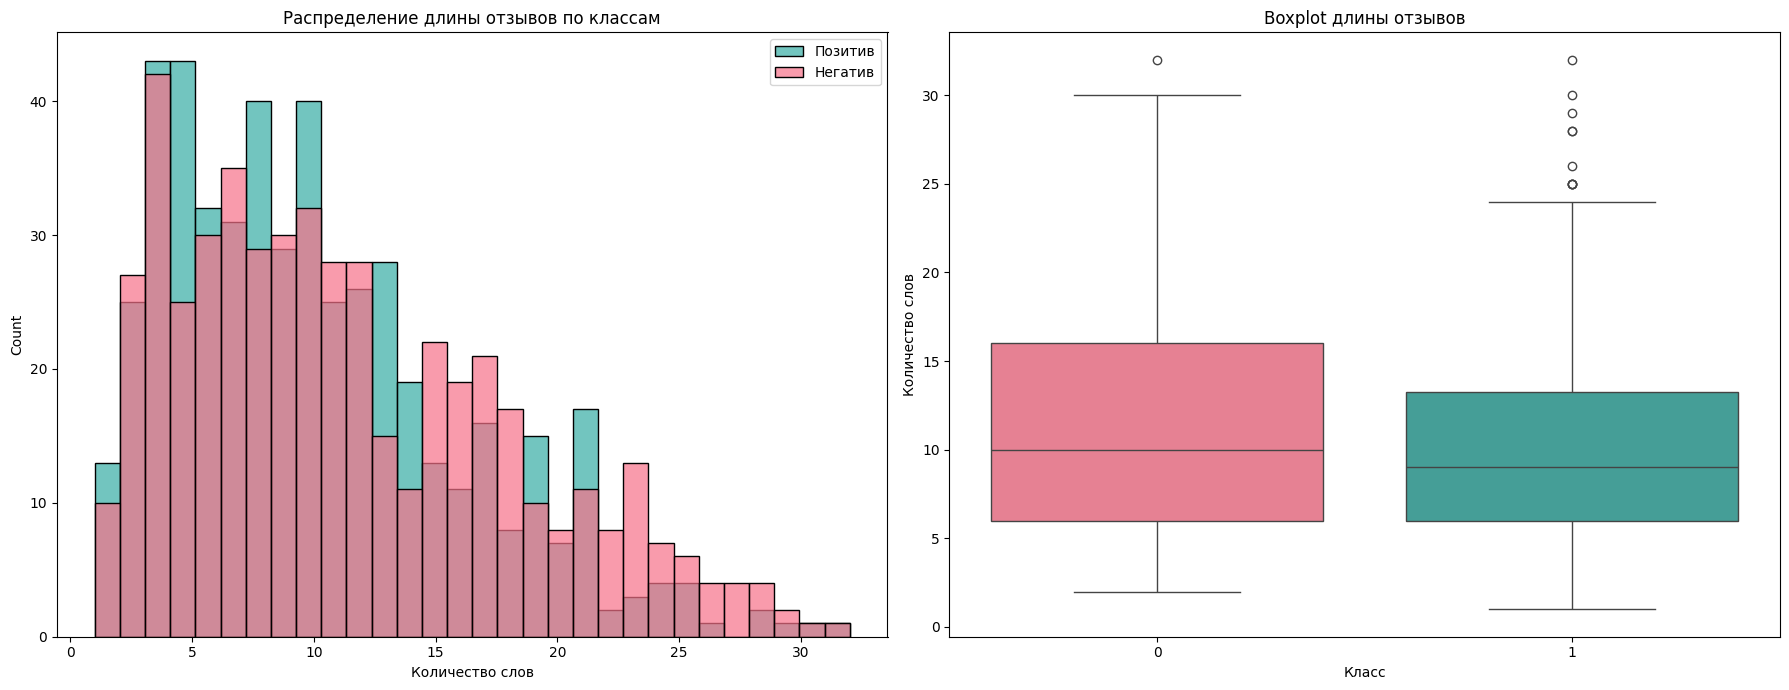

Средняя длина отзыва:
Liked
0    11.498
1    10.290
Name: length, dtype: float64


In [42]:
# Добавляем длину текста
reviews['length'] = reviews['Review'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Гистограмма длин
sns.histplot(data=reviews, x='length', hue='Liked', palette='husl', bins=30, ax=axes[0], alpha=0.7)
axes[0].set_title('Распределение длины отзывов по классам')
axes[0].set_xlabel('Количество слов')
axes[0].legend(['Позитив', 'Негатив'])

# Boxplot
sns.boxplot(data=reviews, x='Liked', y='length', palette='husl', ax=axes[1])
axes[1].set_title('Boxplot длины отзывов')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Количество слов')

plt.tight_layout()
plt.show()

print("Средняя длина отзыва:")
print(reviews.groupby('Liked')['length'].mean())

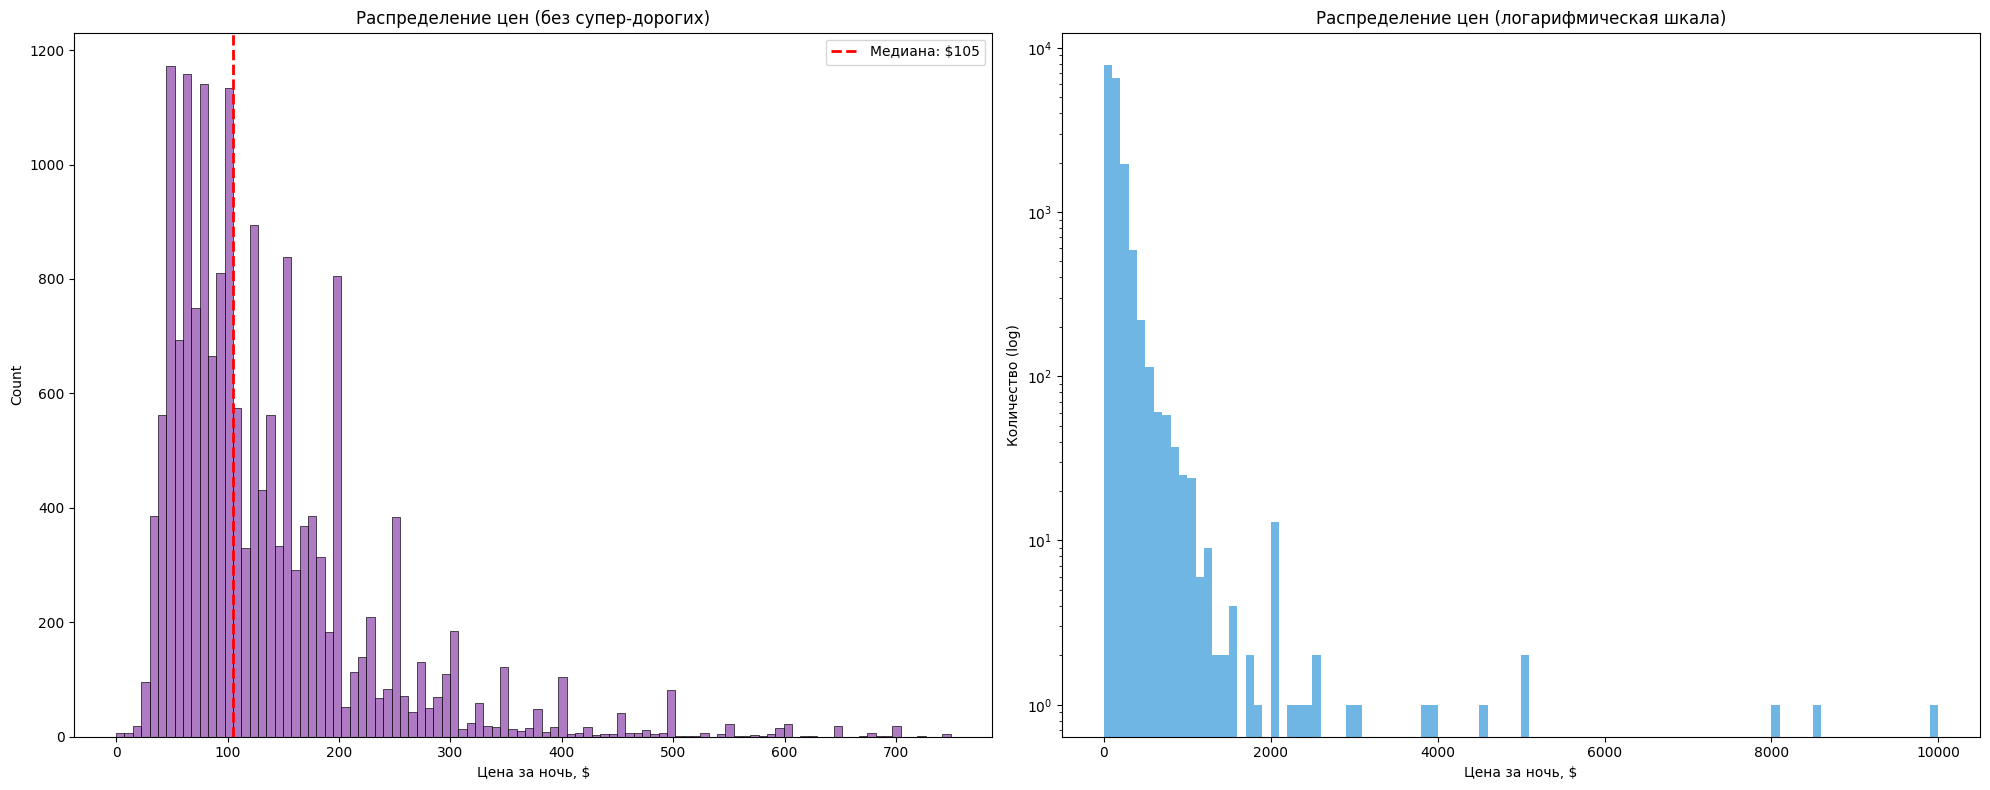

Средняя цена: $145.46
Медианная цена: $109.00
Макс цена: $9999.00
99% квантиль: $750.00


In [43]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Обычная гистограмма (с обрезкой выбросов)
ny_filtered = ny[ny['price'] < ny['price'].quantile(0.99)]  # убираем топ-1%
sns.histplot(ny_filtered['price'], bins=100, ax=axes[0], color='#9b59b6', alpha=0.8)
axes[0].set_title('Распределение цен (без супер-дорогих)')
axes[0].set_xlabel('Цена за ночь, $')
axes[0].axvline(ny_filtered['price'].median(), color='red', linestyle='--', linewidth=2, label=f"Медиана: ${ny_filtered['price'].median():.0f}")
axes[0].legend()

# Логарифмическая шкала
axes[1].hist(ny['price'], bins=100, color='#3498db', alpha=0.7, log=True)
axes[1].set_title('Распределение цен (логарифмическая шкала)')
axes[1].set_xlabel('Цена за ночь, $')
axes[1].set_ylabel('Количество (log)')

plt.tight_layout()
plt.show()

print(f"Средняя цена: ${ny['price'].mean():.2f}")
print(f"Медианная цена: ${ny['price'].median():.2f}")
print(f"Макс цена: ${ny['price'].max():.2f}")
print(f"99% квантиль: ${ny['price'].quantile(0.99):.2f}")

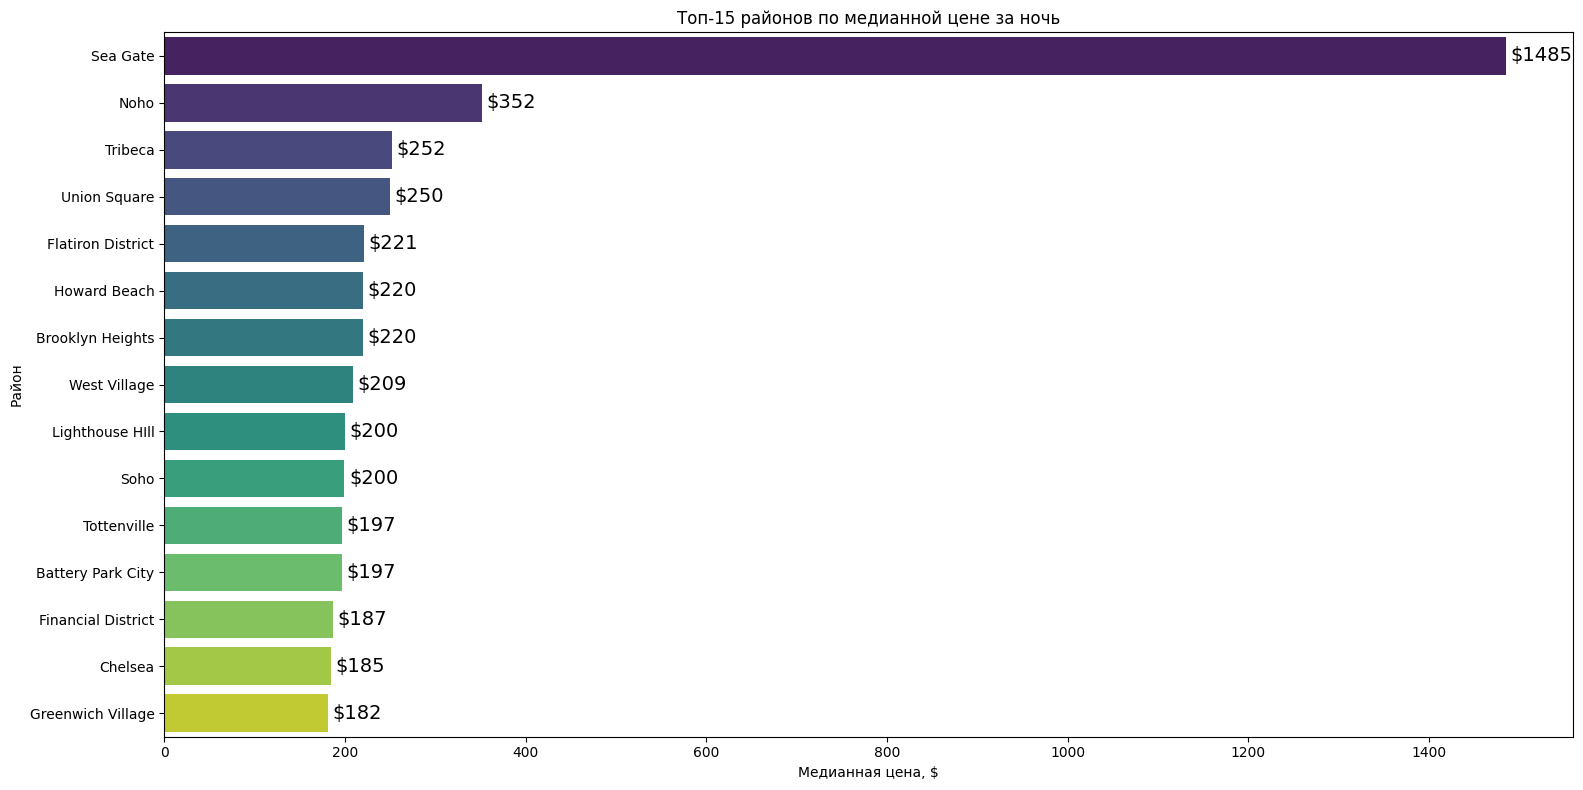

In [44]:
# Топ-15 районов по медианной цене
top_neigh = ny.groupby('neighbourhood')['price'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(16, 8))
sns.barplot(x=top_neigh.values, y=top_neigh.index, palette='viridis')
plt.title('Топ-15 районов по медианной цене за ночь')
plt.xlabel('Медианная цена, $')
plt.ylabel('Район')
for i, v in enumerate(top_neigh.values):
    plt.text(v + 5, i, f"${v:.0f}", va='center', fontsize=14)

plt.tight_layout()
plt.show()

## Предобработка текста отзывов

In [45]:
# Предобработка текста
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Добавлние самых частых и бесполезных слов
extra_stops = {"the", "and", "was", "were", "is", "are", "been", "it'", "it's", "place", "food", "nt"}
stop_words.update(extra_stops)

def clean_and_lemmatize_fast(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)         
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words 
             if w not in stop_words and len(w) > 2]
    return " ".join(words)

reviews['Review_clean'] = reviews['Review'].apply(clean_and_lemmatize_fast)

reviews[['Review', 'Review_clean', 'Liked']].head(10)

,Review,Review_clean,Liked
0,Wow... Loved this place.,wow loved,1
1,Crust is not good.,crust good,0
2,Not tasty and the texture was just nasty.,tasty texture nasty,0
3,Stopped by during the late May bank holiday of...,stopped late may bank holiday rick steve recom...,1
4,The selection on the menu was great and so wer...,selection menu great price,1
5,Now I am getting angry and I want my damn pho.,getting angry want damn pho,0
6,Honeslty it didn't taste THAT fresh.),honeslty didnt taste fresh,0
7,The potatoes were like rubber and you could te...,potato like rubber could tell made ahead time ...,0
8,The fries were great too.,fry great,1
9,A great touch.,great touch,1


In [46]:
# Векторизация текста с TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
    stop_words='english'
)

X_text = vectorizer.fit_transform(reviews['Review_clean'])
y_text = reviews['Liked']

print(f"Размер матрицы: {X_text.shape}")
print(f"Пример слов: {list(vectorizer.vocabulary_.keys())[:20]}")

Размер матрицы: (1000, 445)
Пример слов: ['wow', 'loved', 'good', 'tasty', 'texture', 'nasty', 'recommendation', 'selection', 'menu', 'great', 'price', 'getting', 'want', 'damn', 'pho', 'didnt', 'taste', 'fresh', 'potato', 'like']


In [47]:
# Разделение на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Создаём список для сбора результатов 
results = []

Train size: 800, Test size: 200


In [48]:
# Бейзлайн — Логистическая регрессия

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

logreg_base = LogisticRegression(max_iter=1000, random_state=42)
logreg_base.fit(X_train, y_train)

pred_base = logreg_base.predict(X_test)

acc_base = accuracy_score(y_test, pred_base)
f1_base = f1_score(y_test, pred_base)

print(f"Accuracy: {acc_base:.4f}")
print(f"F1-score: {f1_base:.4f}")

results.append({'Задача': 'Классификация', 
                'Этап': 'Бейзлайн', 
                'Модель': 'LogisticRegression', 
                'Accuracy': acc_base, 
                'F1': f1_base})

Accuracy: 0.7850
F1-score: 0.7882


In [49]:
features_reg = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'availability_2020', 'days_occupied_in_2019']
X_reg = ny[features_reg].fillna(0)
y_reg = ny['price']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [50]:
# Бейзлайн — Линейная регрессия 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


linreg_base = LinearRegression()
linreg_base.fit(X_train_r, y_train_r)
pred_reg = linreg_base.predict(X_test_r)

mae_base = mean_absolute_error(y_test_r, pred_reg)
rmse_base = np.sqrt(mean_squared_error(y_test_r, pred_reg))

print(f"MAE:  {mae_base:.2f}")
print(f"RMSE: {rmse_base:.2f}")

results.append({
    'Задача': 'Регрессия', 
    'Этап': 'Бейзлайн', 
    'Модель': 'LinearRegression', 
    'MAE': mae_base, 
    'RMSE': rmse_base
})

MAE:  77.41
RMSE: 175.26


In [51]:
# Улучшенная классификация — Логистическая регрессия + улучшенный TF-IDF

vectorizer_imp = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words='english'
)

X_clf_imp = vectorizer_imp.fit_transform(reviews['Review_clean'])
y_clf = reviews['Liked']

X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(
    X_clf_imp, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)


best_logreg_imp = LogisticRegression(
    C=1.0,        
    penalty='l2',   
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

best_logreg_imp.fit(X_train_c2, y_train_c2)
pred_clf_imp = best_logreg_imp.predict(X_test_c2)
proba_clf_imp = best_logreg_imp.predict_proba(X_test_c2)[:, 1]

acc_imp = accuracy_score(y_test_c2, pred_clf_imp)
f1_imp = f1_score(y_test_c2, pred_clf_imp)

print(f"Accuracy: {acc_imp:.4f}")
print(f"F1-score: {f1_imp:.4f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_c2, proba_clf_imp):.4f}")

results.append({
    'Задача': 'Классификация', 
    'Этап': 'Улучшенный (ngrams + max_features)', 
    'Модель': 'LogisticRegression', 
    'Accuracy': acc_imp, 
    'F1': f1_imp
})

Accuracy: 0.7800
F1-score: 0.7778
ROC-AUC:  0.8741


In [52]:
# Улучшенная регрессия — Линейная регрессия

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

df_reg = ny[(ny['price'] > 10) & (ny['price'] < 800)].copy()
df_reg['log_price'] = np.log1p(df_reg['price'])

times_square_lat = 40.7580
times_square_lon = -73.9855
df_reg['dist_to_center'] = np.sqrt(
    (df_reg['latitude'] - times_square_lat)**2 + 
    (df_reg['longitude'] - times_square_lon)**2
) * 111  # в км

features_reg = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'availability_2020', 'days_occupied_in_2019', 'dist_to_center']

X_reg_imp = df_reg[features_reg].fillna(0)
y_reg_imp = df_reg['log_price']

X_train_r2, X_test_r2, y_train_r2, y_test_r2 = train_test_split(
    X_reg_imp, y_reg_imp, test_size=0.2, random_state=42
)

linreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

linreg_pipe.fit(X_train_r2, y_train_r2)
pred_log = linreg_pipe.predict(X_test_r2)
pred_price = np.expm1(pred_log)        # возвращаем из логарифма
true_price = np.expm1(y_test_r2)

mae_imp = mean_absolute_error(true_price, pred_price)
rmse_imp = np.sqrt(mean_squared_error(true_price, pred_price))

print(f"MAE:  {mae_imp:.2f}   (было в бейзлайне: {mae_base:.2f})")
print(f"RMSE: {rmse_imp:.2f}")

results.append({
    'Задача': 'Регрессия',
    'Этап': 'Улучшенный (лог-цена + dist_to_center + scaler)',
    'Модель': 'LinearRegression',
    'MAE': mae_imp,
    'RMSE': rmse_imp
})

MAE:  60.07   (было в бейзлайне: 77.41)
RMSE: 95.87


In [53]:
# Собственная реализация линейной и логистической регрессии

class MyLinearRegression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
    
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        y = y.reshape(-1, 1)
        theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.intercept_ = theta[0][0]
        self.coef_ = theta[1:].flatten()
    
    def predict(self, X):
        return X.dot(self.coef_) + self.intercept_

class MyLogisticRegression:
    def __init__(self, lr=0.01, n_iters=1000, C=1.0):
        self.lr = lr      
        self.n_iters = n_iters
        self.C = C          
        self.coef_ = None
        self.intercept_ = None
    
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X] 
        n_features = X_b.shape[1]
        
        self.w = np.zeros((n_features, 1))
        y = y.reshape(-1, 1)
        
        for i in range(self.n_iters):
            y_pred = expit(X_b.dot(self.w))           
            gradient = X_b.T.dot(y_pred - y) / len(y)  
            reg = np.vstack([0, self.w[1:]]) * (1/self.C)
            gradient += reg / len(y)
            
            self.w -= self.lr * gradient
            
            if i > 100 and np.linalg.norm(gradient) < 1e-6:
                break
        
        self.intercept_ = self.w[0][0]
        self.coef_ = self.w[1:].flatten()
    
    def predict_proba(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        proba = expit(X_b.dot(self.w))
        return np.hstack([1 - proba, proba])
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

In [54]:
# Классификация с собственной реализацией логистической регрессии

from scipy.special import expit

y_train_np = y_train_c2.values if hasattr(y_train_c2, 'values') else np.array(y_train_c2)
y_test_np  = y_test_c2.values  if hasattr(y_test_c2,  'values') else np.array(y_test_c2)

my_logreg = MyLogisticRegression(lr=0.05, n_iters=3000, C=1.0)
my_logreg.fit(
    X_train_c2.toarray() if hasattr(X_train_c2, 'toarray') else X_train_c2,
    y_train_np
)

pred_my_log = my_logreg.predict(
    X_test_c2.toarray() if hasattr(X_test_c2, 'toarray') else X_test_c2
)

acc_my = accuracy_score(y_test_np, pred_my_log)
f1_my  = f1_score(y_test_np, pred_my_log)

print(f"Accuracy: {acc_my:.4f}")
print(f"F1-score: {f1_my:.4f}")

results.append({
    'Задача': 'Классификация',
    'Этап': 'Своя реализация',
    'Модель': 'MyLogisticRegression',
    'Accuracy': acc_my,
    'F1': f1_my
})

Accuracy: 0.7800
F1-score: 0.7684


In [55]:
# Регрессия с собственной реализацией линейной регрессии

y_train_np = y_train_r2.values if hasattr(y_train_r2, 'values') else np.array(y_train_r2)
y_test_np  = y_test_r2.values  if hasattr(y_test_r2,  'values') else np.array(y_test_r2)

my_linreg = MyLinearRegression()
my_linreg.fit(X_train_r2, y_train_np)  

pred_log_my = my_linreg.predict(X_test_r2)
pred_price_my = np.expm1(pred_log_my)
true_price = np.expm1(y_test_np)        

mae_my = mean_absolute_error(true_price, pred_price_my)
rmse_my = np.sqrt(mean_squared_error(true_price, pred_price_my))

print(f"MAE:  {mae_my:.2f}")
print(f"RMSE: {rmse_my:.2f}")

results.append({
    'Задача': 'Регрессия',
    'Этап': 'Своя реализация',
    'Модель': 'MyLinearRegression',
    'MAE': mae_my,
    'RMSE': rmse_my
})

MAE:  60.07
RMSE: 95.87


In [56]:
# Своя линейная регрессия + улучшения


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_r2)
X_test_scaled = scaler.transform(X_test_r2)

y_train_np = y_train_r2.values if hasattr(y_train_r2, 'values') else np.array(y_train_r2)
y_test_np  = y_test_r2.values  if hasattr(y_test_r2,  'values') else np.array(y_test_r2)

my_linreg_scaled = MyLinearRegression()
my_linreg_scaled.fit(X_train_scaled, y_train_np)

pred_log_my = my_linreg_scaled.predict(X_test_scaled)
pred_price_my = np.expm1(pred_log_my)
true_price = np.expm1(y_test_np)

mae_my_scaled = mean_absolute_error(true_price, pred_price_my)
rmse_my_scaled = np.sqrt(mean_squared_error(true_price, pred_price_my))

print(f"MAE:  {mae_my_scaled:.2f}")
print(f"RMSE: {rmse_my_scaled:.2f}")

results.append({
    'Задача': 'Регрессия',
    'Этап': 'Своя + масштабирование',
    'Модель': 'MyLinearRegression',
    'MAE': mae_my_scaled,
    'RMSE': rmse_my_scaled
})

MAE:  60.07
RMSE: 95.87


In [57]:
# Финальные таблицы результатов

final_df = pd.DataFrame(results)

print("\n1. Классификация отзывов (Accuracy / F1)")
clf_df = final_df[final_df['Задача'] == 'Классификация'][['Этап', 'Модель', 'Accuracy', 'F1']].round(4)
display(clf_df.style
        .background_gradient(cmap='Greens', subset=['Accuracy', 'F1'])
        .set_caption("Классификация отзывов")
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold')]}]))

print("\n2. Регрессия цен на жильё в Нью-Йорке (MAE / RMSE)")
reg_df = final_df[final_df['Задача'] == 'Регрессия'][['Этап', 'Модель', 'MAE', 'RMSE']].round(2)
reg_df = reg_df.fillna('-')  # если где-то нет RMSE

display(reg_df.style
        .background_gradient(cmap='Blues', subset=['MAE', 'RMSE'])
        .set_caption("Регрессия цен (Airbnb NY)")
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold')]}]))

print("\nОбщая таблица всех экспериментов:")
display(final_df.round(4))


1. Классификация отзывов (Accuracy / F1)


,Этап,Модель,Accuracy,F1
0,Бейзлайн,LogisticRegression,0.785000,0.788200
2,Улучшенный (ngrams + max_features),LogisticRegression,0.780000,0.777800
4,Своя реализация,MyLogisticRegression,0.780000,0.768400



2. Регрессия цен на жильё в Нью-Йорке (MAE / RMSE)


,Этап,Модель,MAE,RMSE
1,Бейзлайн,LinearRegression,77.410000,175.260000
3,Улучшенный (лог-цена + dist_to_center + scaler),LinearRegression,60.070000,95.870000
5,Своя реализация,MyLinearRegression,60.070000,95.870000
6,Своя + масштабирование,MyLinearRegression,60.070000,95.870000



Общая таблица всех экспериментов:


,Задача,Этап,Модель,Accuracy,F1,MAE,RMSE
0,Классификация,Бейзлайн,LogisticRegression,0.785,0.7882,NaN,NaN
1,Регрессия,Бейзлайн,LinearRegression,NaN,NaN,77.4082,175.2617
2,Классификация,Улучшенный (ngrams + max_features),LogisticRegression,0.780,0.7778,NaN,NaN
3,Регрессия,Улучшенный (лог-цена + dist_to_center + scaler),LinearRegression,NaN,NaN,60.0708,95.8692
4,Классификация,Своя реализация,MyLogisticRegression,0.780,0.7684,NaN,NaN
5,Регрессия,Своя реализация,MyLinearRegression,NaN,NaN,60.0708,95.8692
6,Регрессия,Своя + масштабирование,MyLinearRegression,NaN,NaN,60.0708,95.8692
